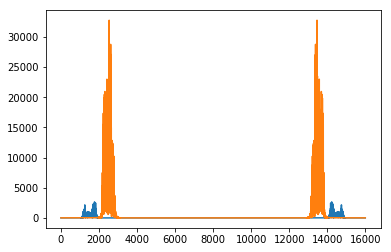

1


In [51]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython
import string
import math
import scipy.signal as sgn

import pyaudio
import wave

from helpers import *

# CONSTANTS

NUMBER_OF_SYMBOLS = 128 + 10 # 10 bonus symbols to have time for sending and all

Fs = 16000 # sampling freqency
T=.6 # transmission time per symbol
TWOPI = 2 * np.pi

min_freq = 1000
max_freq = 2000

rolloff = 0.1

tolerance = 8 # the max ratio between the loudest and the less loud freqencies recieved

# Record initial noise !!

CHUNKSIZE = int(2*Fs) # 2 time slots

# initialize portaudio
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=Fs, input=True, frames_per_buffer=CHUNKSIZE)

# do this as long as you want fresh samples
data1 = stream.read(CHUNKSIZE)
numpydata = np.fromstring(data1, dtype=np.int16)

noise = numpydata/1 # need to change the amplitude ??

# close stream
stream.stop_stream()
stream.close()
p.terminate()

# Check presence of silence between 1kHz and 2kHz
noise12 = butter_bandpass_filter(noise, 1200, 1800, Fs, order=10)
amplitude12 = np.mean(abs(noise12))

# Check presence of silence between 2kHz and 3kHz
noise23 = butter_bandpass_filter(noise, 2200, 2800, Fs, order=10)
amplitude23 = np.mean(abs(noise23))

# Plot
plt.plot(abs(np.fft.fft(noise12, Fs)))
plt.plot(abs(np.fft.fft(noise23, Fs)))
plt.show()

NOISE_RANGE=0 
if (abs(amplitude12) < abs(amplitude23)):
    NOISE_RANGE=1
else:
    NOISE_RANGE=2

if(NOISE_RANGE==2):
    freq_shift=1000
else:
    freq_shift=0

my_alphabet = ['ü'] + list(string.printable) #our alphabet

#transforms a character from our alphabet to its binary representation
def toBinary(c):
    my_index = my_alphabet.index(c)
    toBinary = bin(my_index)
    return toBinary[2:] # we remove the header "0b"

number_bits = int(math.ceil(np.log2(len(my_alphabet)))) # the number of bits we require to represent our alphabet
my_base = np.linspace(min_freq, max_freq, num = math.ceil(number_bits+2)) # +2 because we dont need the borders (1000 and 2000)
#ON DOIT BIEN AUSSI SHIFTER LE LIN SPACE DANS CE CAS NON ??

base_distance = my_base[1] - my_base[0] # distance between 2 waves freqs

print(NOISE_RANGE)

In [52]:
# Record full stream at once.
CHUNKSIZE = int(NUMBER_OF_SYMBOLS*T*Fs) # length of 10 symbols
SYMBOLSIZE = int(T*Fs)

# initialize portaudio
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=Fs, input=True, frames_per_buffer=CHUNKSIZE)

data = stream.read(CHUNKSIZE)
stream.stop_stream()
stream.close()
p.terminate()

full_transmission = np.fromstring(data, dtype=np.int16)
filtered_transmission = butter_bandpass_filter(full_transmission[8000:], 990+freq_shift, 1990+freq_shift, Fs, order=7) # 8000 for not hearing the initial touch press pop

begin = 0
max_t = np.max(filtered_transmission[:int(3*T*Fs)])
tresh = 1/2*max_t

for i in range(0, len(filtered_transmission)):
    if(np.mean(filtered_transmission[i:i+100]>tresh)):
        begin = i
        break
        
filtered_transmission = filtered_transmission[begin+Fs:] # We begin to use the signal after the clap only

end = 0

for i in range(0, len(filtered_transmission)):
    if(np.mean(filtered_transmission[len(filtered_transmission)-(i+100):len(filtered_transmission)-i]>tresh)):
        end = len(filtered_transmission)-i
        break
        
filtered_transmission = filtered_transmission[:end-Fs] 

def chunker(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]
    
filter_symbol = list(chunker(filtered_transmission, int(SYMBOLSIZE))) 
len(filter_symbol[0])

decoded = []

for raw_symbol in filter_symbol :
    
    filtered_symbol = [] # laisser l'order très bas (1 ou 2) sinon ça marche plus   
    for i in range (1, 8):
        filtered_symbol.append(butter_bandpass_filter(raw_symbol, my_base[i]+freq_shift-base_distance/2, my_base[i]+freq_shift+base_distance/2, Fs, order=1))
        #filtered_symbol.append(raw_symbol)
    
    # freqs we wanna check if present or not in the sent wave
    freq_cosine = []
    for i in range (1, 8):
        freq_cosine.append(raised_cosine(my_base[i]+freq_shift, T, Fs, roll_off=rolloff))

    # x-corr to see if present in the signal
    correlated_symbol = []
    for i in range (0, 7):
        correlated_symbol.append(sgn.correlate(filtered_symbol[i], freq_cosine[i], mode='same'))
    
    # Compute the average amplitude of the corss-correlation (of high, the freq is present, else it is not)
    amplitude_symbol = []
    for i in range (0, 7):
        amplitude_symbol.append(np.mean(abs(correlated_symbol[i])))
    
    # Compute the max and the min of the amplitudes (of the amps are nearer to the max amp we say that the freq was sent, else not)
    max_amp = np.max(amplitude_symbol)
    min_amp = np.min(amplitude_symbol)

    # Finally tell if freq present (1) or not (0)
    decoded_symbol = []
    for i in range (0, 7):
        decoded_symbol.append(1 if abs(amplitude_symbol[i] - max_amp) < tolerance*abs(amplitude_symbol[i] - min_amp) else 0)
        
    decoded.append(list(reversed(decoded_symbol)))


final_index = []
for binary in decoded :
    s = ''
    for bit in binary :
        s += str(bit)
    final_index.append(int(s, 2))
    
final_index

final_message = ''
for index in final_index :
    if index < 101 : #On devrait pas avoir à verifier ça normalement mais parfois on a des chiffres trop grands
        final_message += my_alphabet[index]
    else : 
        final_message += ' '
        

        
print(NOISE_RANGE) 
print("\n")
print(final_message)

1


0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	
                          Z!


In [46]:
len(final_message)

128

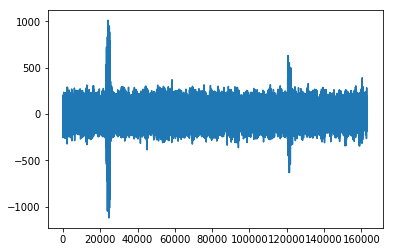

In [34]:
plt.plot(full_transmission)

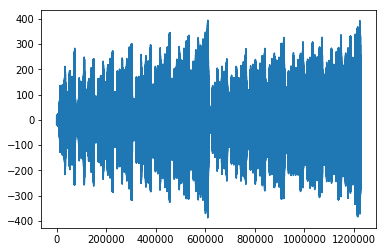

In [50]:
plt.plot(filtered_transmission)

0


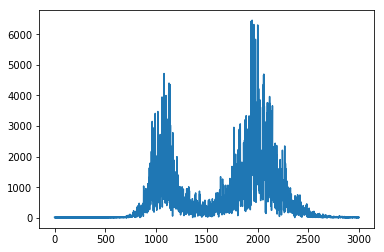

1


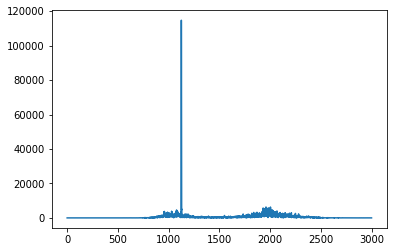

2


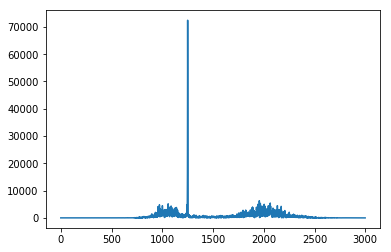

3


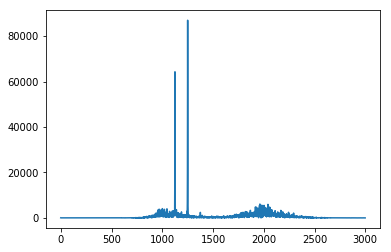

4


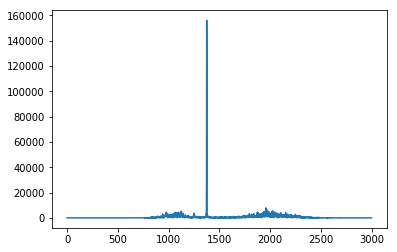

5


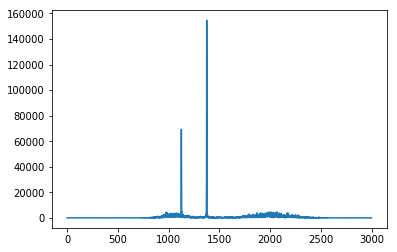

6


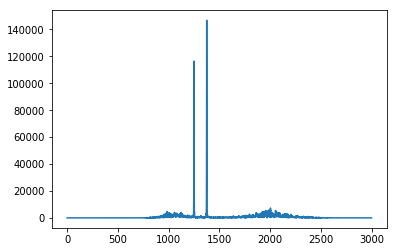

7


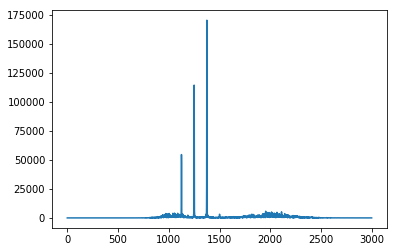

8


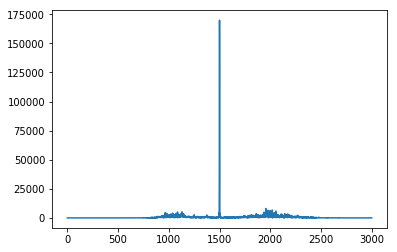

9


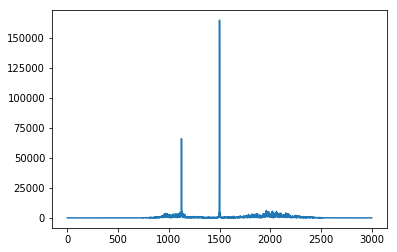

10


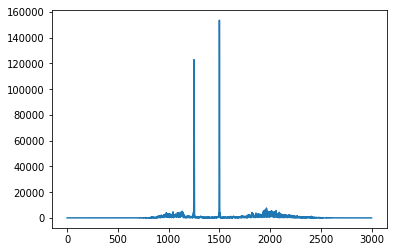

11


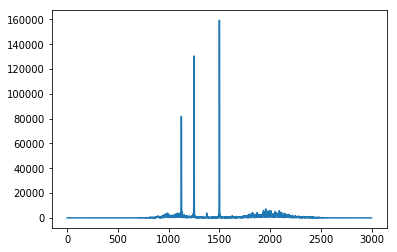

12


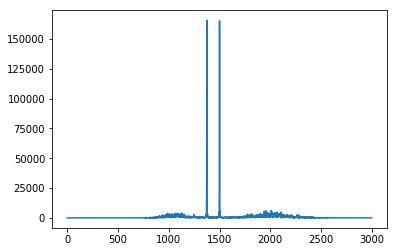

13


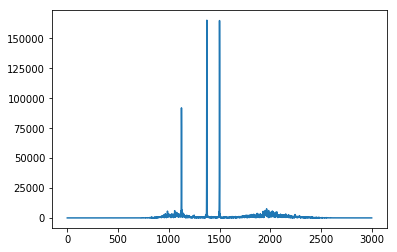

14


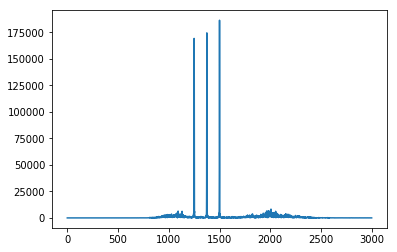

15


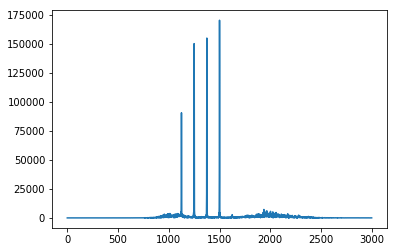

16


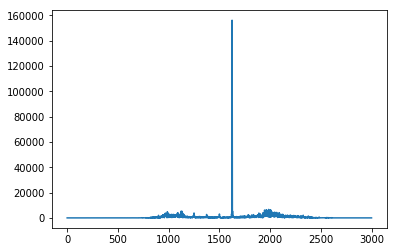

17


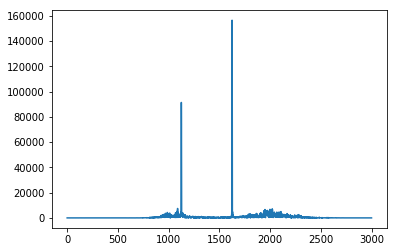

18


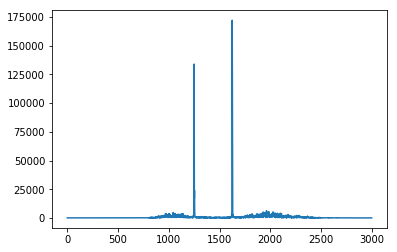

19


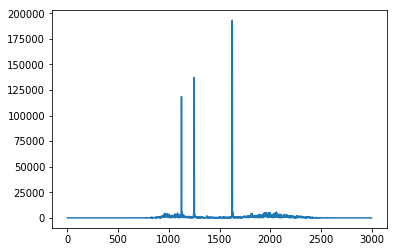

20


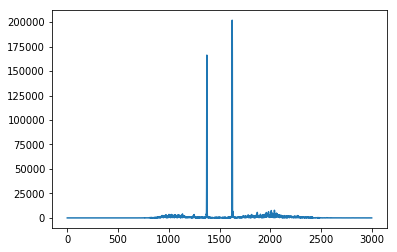

21


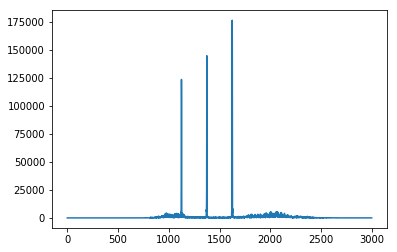

22


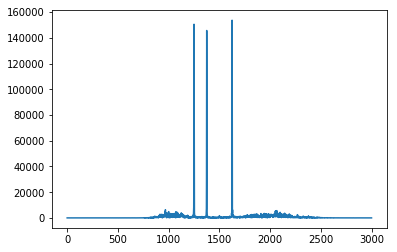

23


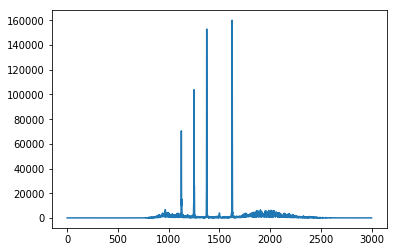

24


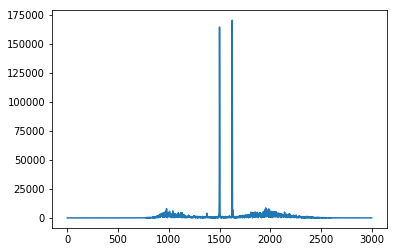

25


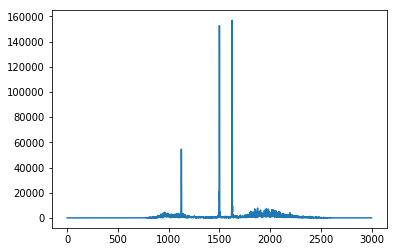

26


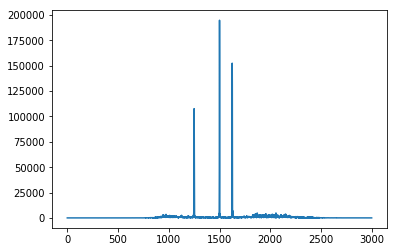

27


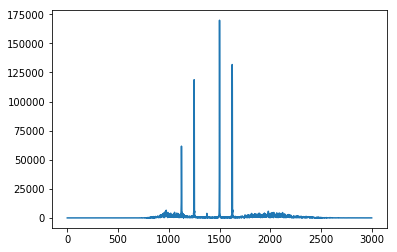

28


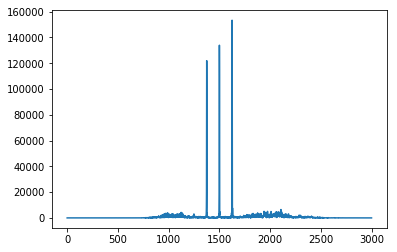

29


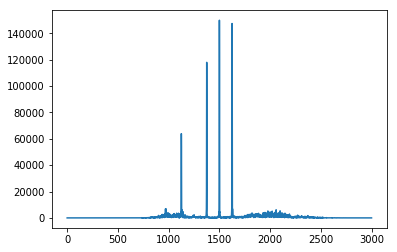

30


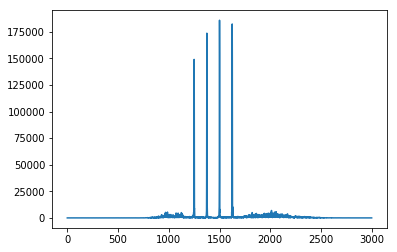

31


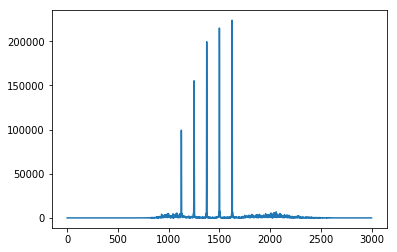

32


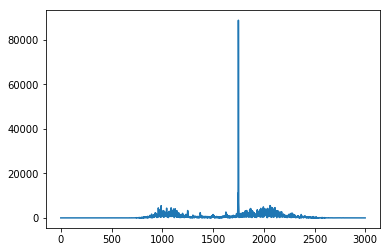

33


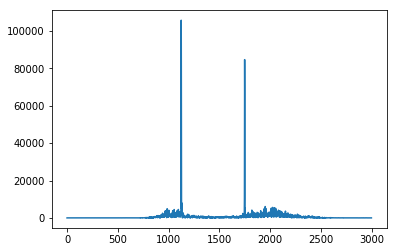

34


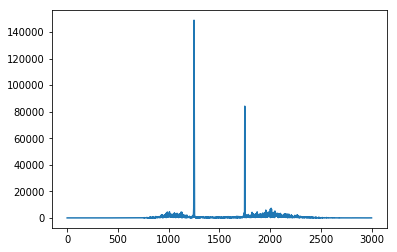

35


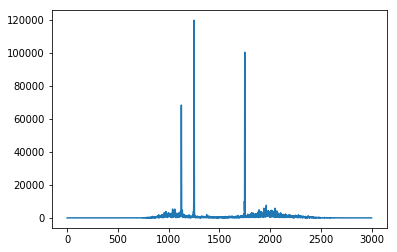

36


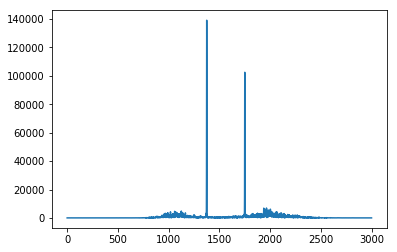

37


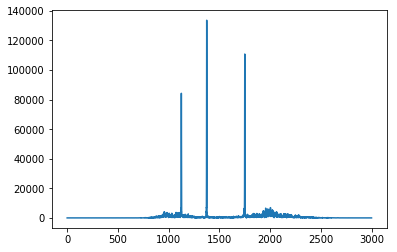

38


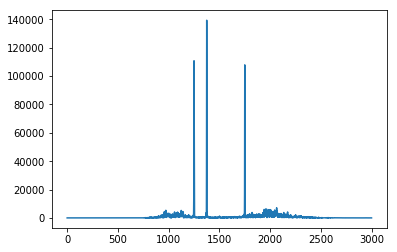

39


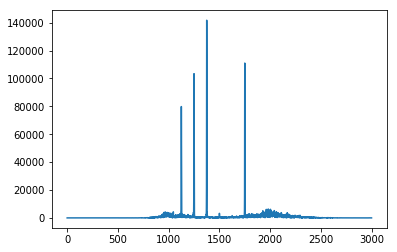

40


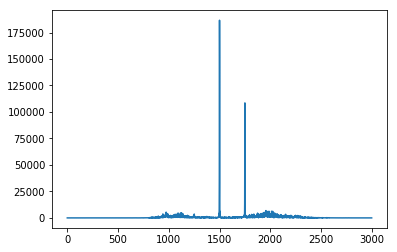

41


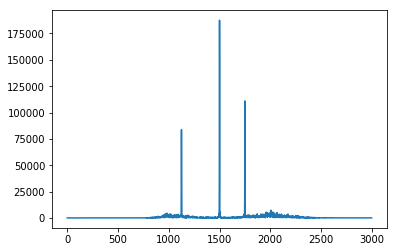

42


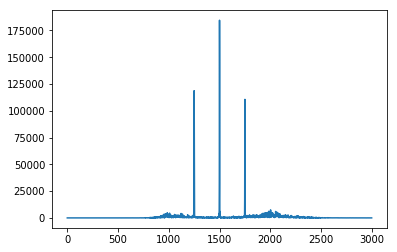

43


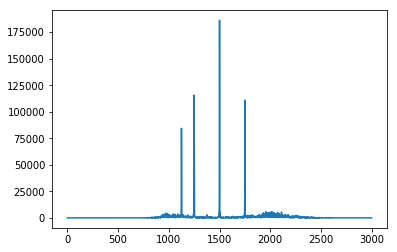

44


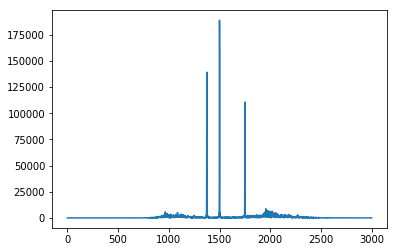

45


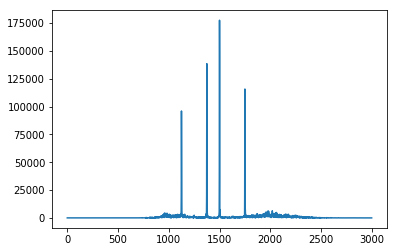

46


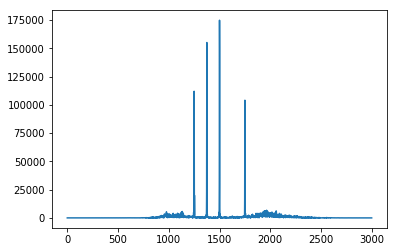

47


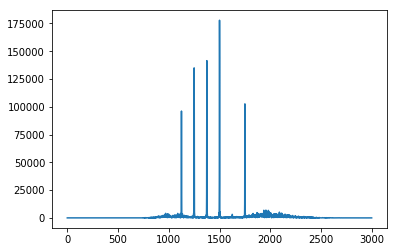

48


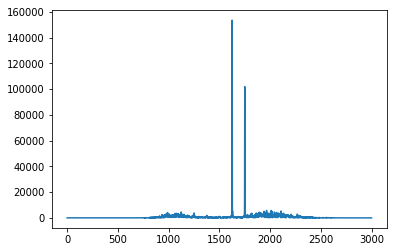

49


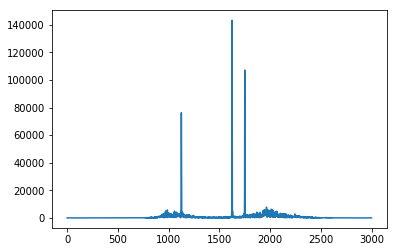

50


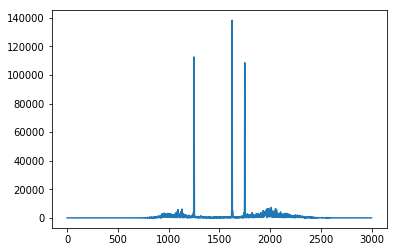

51


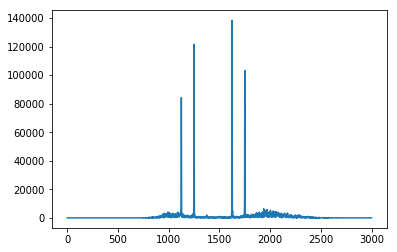

52


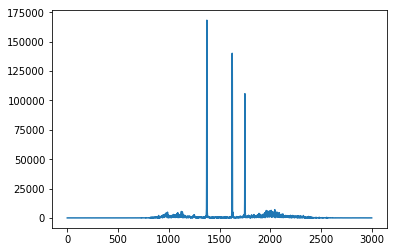

53


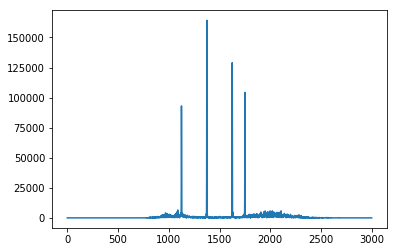

54


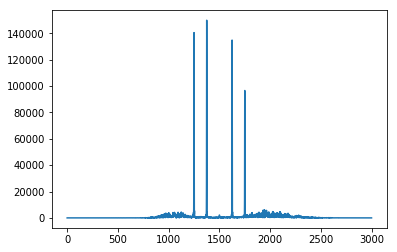

55


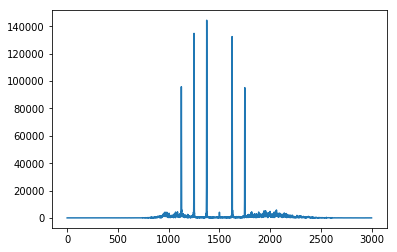

56


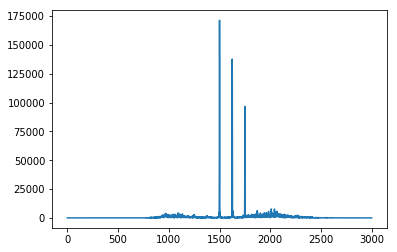

57


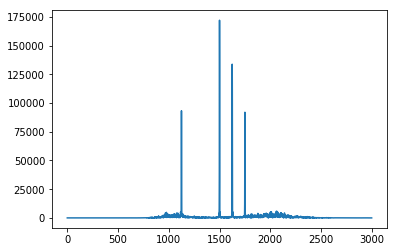

58


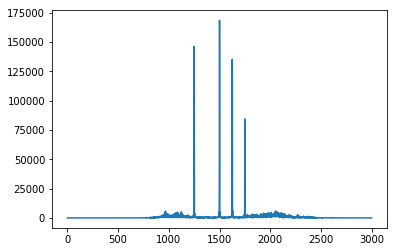

59


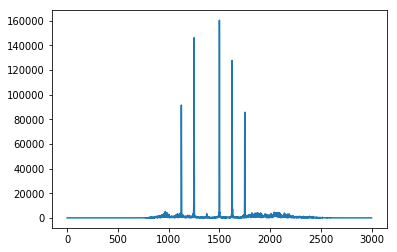

60


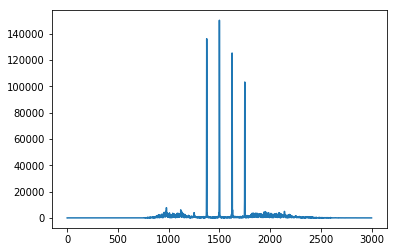

61


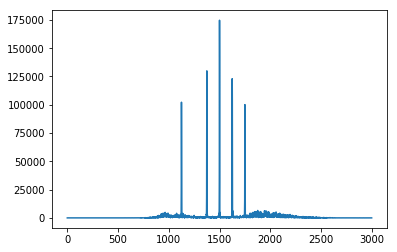

62


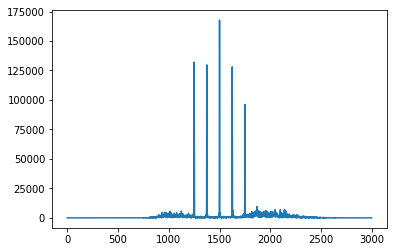

63


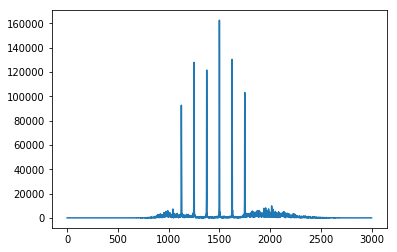

64


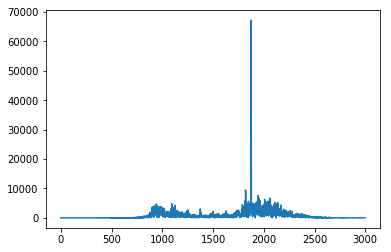

65


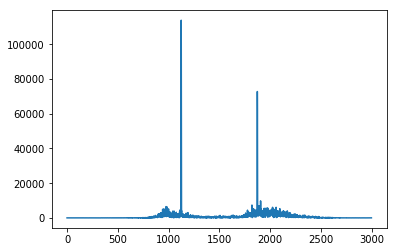

66


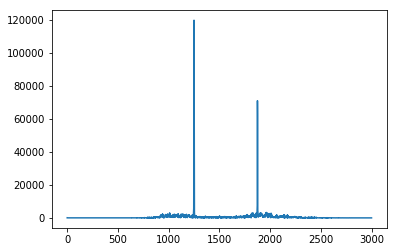

67


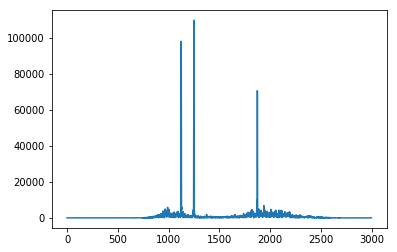

68


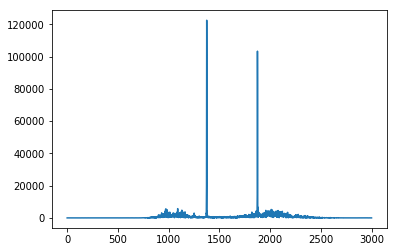

69


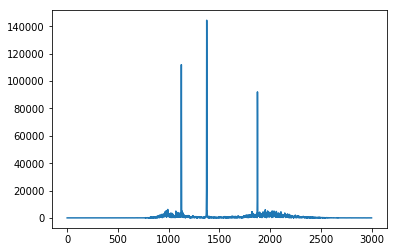

70


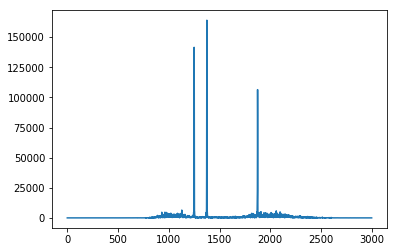

71


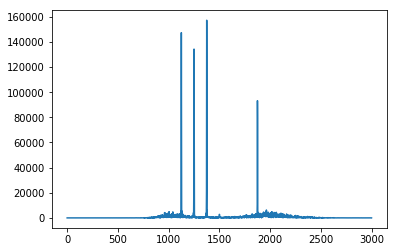

72


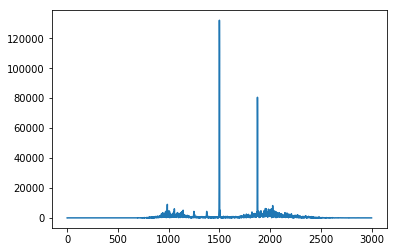

73


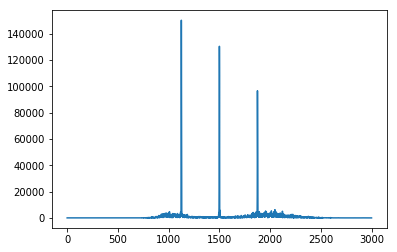

74


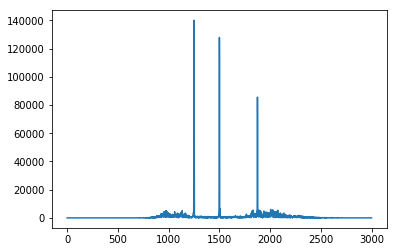

75


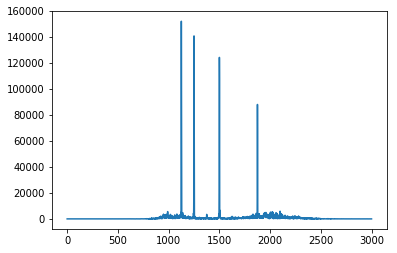

76


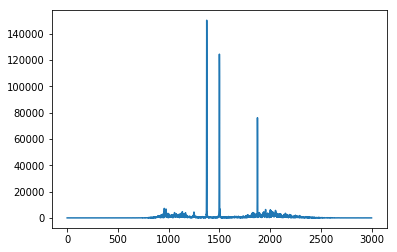

77


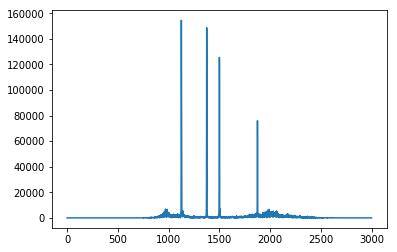

78


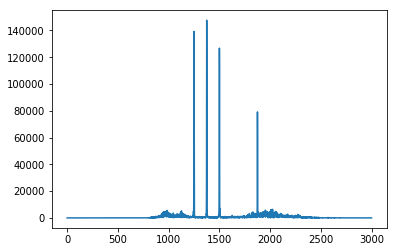

79


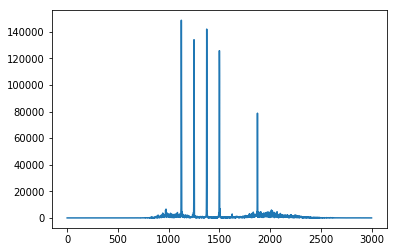

80


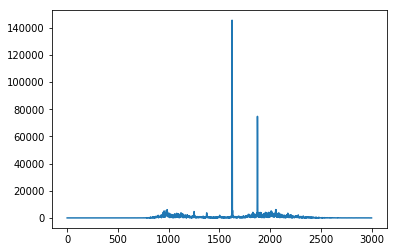

81


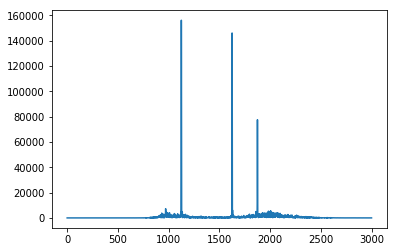

82


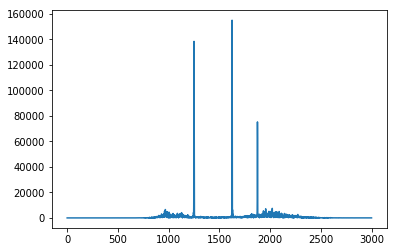

83


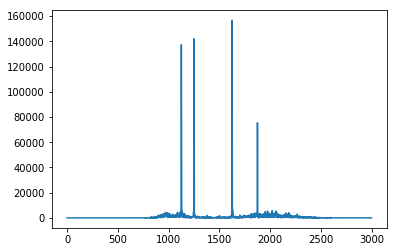

84


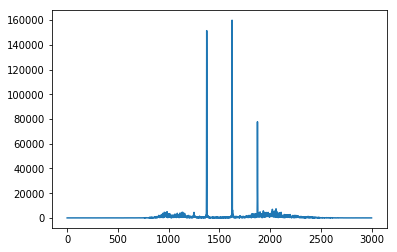

85


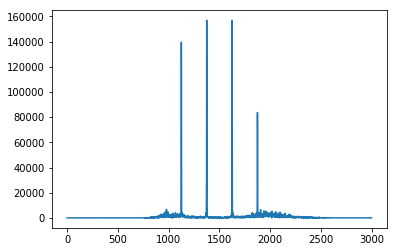

86


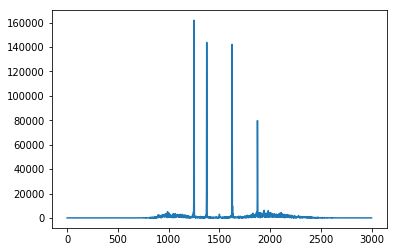

87


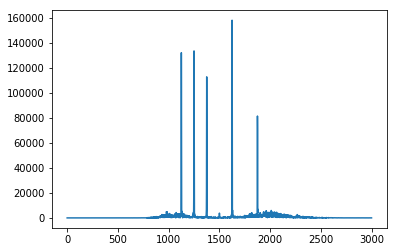

88


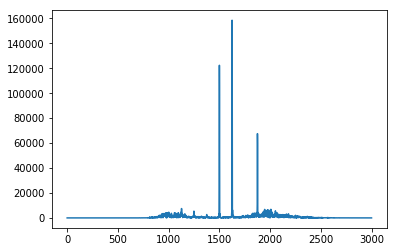

89


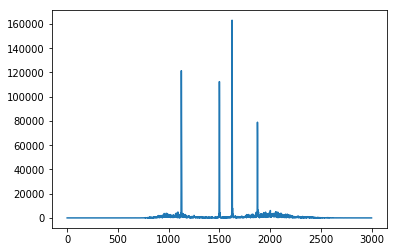

90


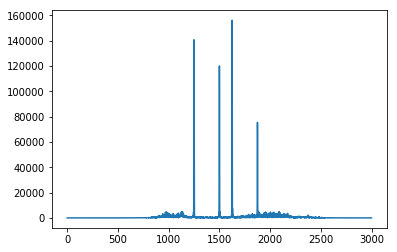

91


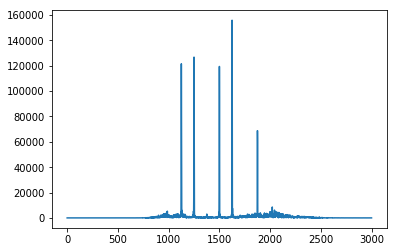

92


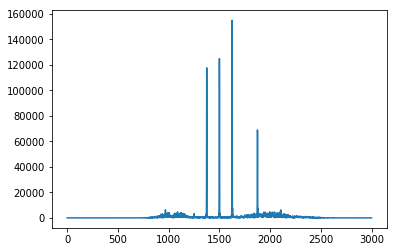

93


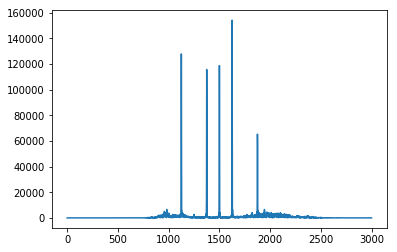

94


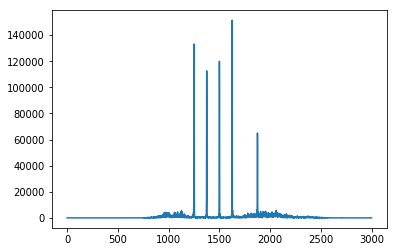

95


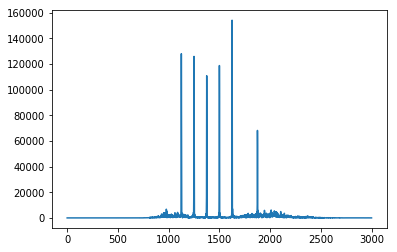

96


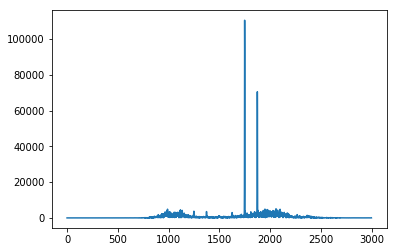

97


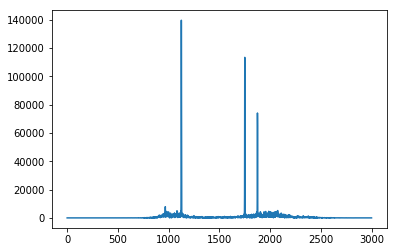

98


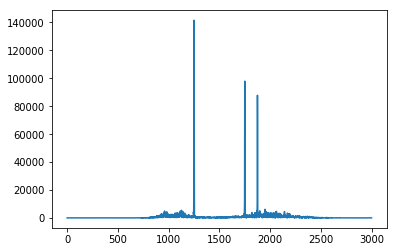

99


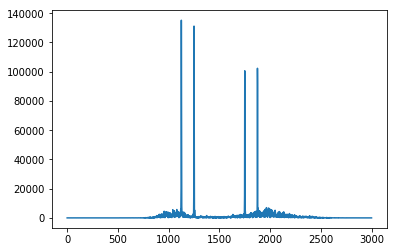

100


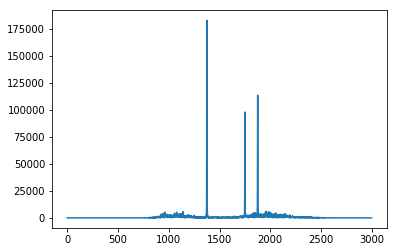

101


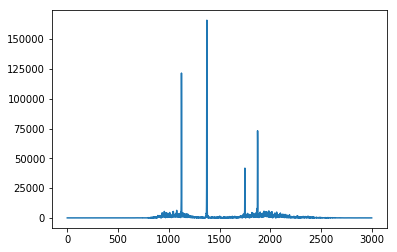

102


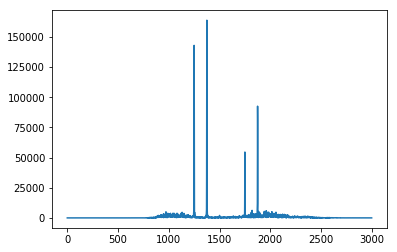

103


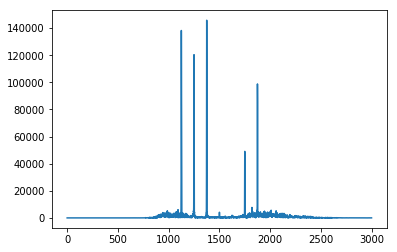

104


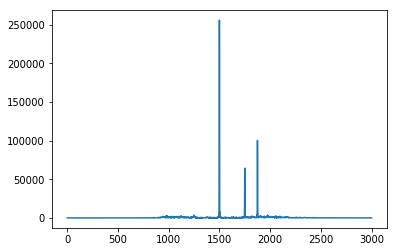

105


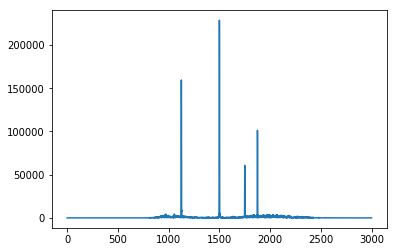

106


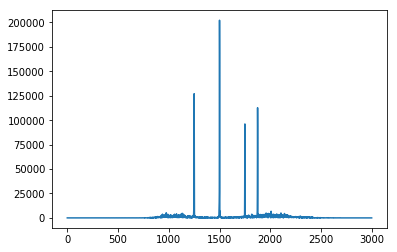

In [ ]:
for i in range(0,128) :
    print(i)
    plt.plot(abs(np.fft.fft(filtered_transmission[int(i*T*Fs):int((i+1)*T*Fs)], Fs))[0:3000])
    plt.show()